In [1]:
import os
import random
import re
import string
from collections import Counter

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download("stopwords")

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [3]:
df = pd.read_csv('./data/new_papers.csv')
df = df.drop_duplicates()
print(df.shape)
df.head()

(49296, 5)


,Conference,Year,Title,Author,Affiliation
0,NeurIPS,2006,Attentional Processing on a Spike-Based VLSI N...,Yingxue Wang,"Swiss Federal Institute of Technology, Zurich"
1,NeurIPS,2006,Attentional Processing on a Spike-Based VLSI N...,Rodney J Douglas,Institute of Neuroinformatics
2,NeurIPS,2006,Attentional Processing on a Spike-Based VLSI N...,Shih-Chii Liu,"Institute for Neuroinformatics, University of ..."
3,NeurIPS,2006,Multi-Task Feature Learning,Andreas Argyriou,Ecole Centrale de Paris
4,NeurIPS,2006,Multi-Task Feature Learning,Theos Evgeniou,INSEAD


In [4]:
data = df['Title'].explode().unique()
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data[0]

TaggedDocument(words=['attentional', 'processing', 'on', 'a', 'spike-based', 'vlsi', 'neural', 'network'], tags=['0'])

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm = 0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

In [8]:
# model.save("./assets/d2v.model")
# print("Model Saved")
# temp = model

In [5]:
model= Doc2Vec.load("./assets/d2v.model")
title_embeddings = []
for i in range(len(model.dv)):
  temp = model.dv[i]
  title_embeddings.append(temp)
title_embeddings = np.array(title_embeddings)

In [8]:
def create_node_trace(G):
    # collect node information from G to plot
    node_x = []
    node_y = []
    node_text = []
    node_color = []

    for i, node in enumerate(G.nodes(data=True)):
        # get node x,y position and store
        x, y = node[1]['pos']
        node_x.append(x)
        node_y.append(y)

        node_text.append(node[1]['text'])
        node_color.append(node[1]['color'])

    # create node trace (i.e., scatter plot)
    # make it invisible by default
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=16,
            line_width=0.5,
        ),
        text=node_text,
        visible=False
    )

    return node_trace

In [9]:
def create_edge_trace(G):
    # collect edges information from G to plot
    edge_weight = []
    edge_text = []
    edge_pos = []
    edge_color = []
    
    for edge in G.edges(data=True):
        
        # edge is line connecting two points
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_pos.append([[x0, x1, None], [y0, y1, None]])
        
        # edge line color when drawn
        edge_color.append("black")

    # there is a trace for each edge
    edge_traces = []
    for i in range(len(edge_pos)):
        
        # edge line width
        line_width = 1

        # is scatter because it is line connecting two points
        trace = go.Scatter(
            x=edge_pos[i][0], y=edge_pos[i][1],
            line=dict(width=line_width, color=edge_color[i]),
            mode='lines',
            visible=False
        )
        edge_traces.append(trace)

    return edge_traces

In [10]:
def filter_similarity_matrix_at_step(square_matrix, step_value):
    # copy matrix
    aux = square_matrix.copy()
    
    # set as NaN all values equal to or below threshold value
    aux[aux <= step_value] = np.nan
    
    # return filtered matrix
    return aux

In [11]:
def get_interactive_slider_similarity_graph(square_matrix, slider_values, node_text=None, yaxisrange=None, xaxisrange=None):
    
    # Create figure with plotly
    fig = go.Figure()

    # key: slider value
    # value: list of traces to display for that slider value
    slider_dict = {}
    
    # total number of traces
    total_n_traces = 0
    
    # node positions on plot
    #node_pos = None

    # for each possible value in the slider, create and store traces (i.e., plots)
    for i, step_value in enumerate(slider_values):

        # update similarity matrix for the current step
        aux = filter_similarity_matrix_at_step(square_matrix, step_value)

        # create nx graph from sim matrix
        G = nx.to_networkx_graph(aux)
        
        # remove edges for 0 weight (NaN)
        G.remove_edges_from([(a, b) for a, b, attrs in G.edges(data=True) if np.isnan(attrs["weight"])])

        # assign node positions if None
        node_pos = nx.nx_pydot.graphviz_layout(G)

        # populate nodes with meta information
        for node in G.nodes(data=True):
            
            # node position
            node[1]['pos'] = node_pos[node[0]]

            # node color
            node[1]['color'] = "orange"

            # node text on hover if any is specified else is empty
            if node_text is not None:
                node[1]['text'] = node_text[node[0]]
            else:
                node[1]['text'] = ""

        # create edge taces (each edge is a trace, thus this is a list)
        edge_traces = create_edge_trace(G)
        
        # create node trace (a single trace for all nodes, thus it is not a list)
        node_trace = create_node_trace(G) 

        # store edge+node traces as single list for the current step value
        slider_dict[step_value] = edge_traces + [node_trace]
        
        # keep count of the total number of traces
        total_n_traces += len(slider_dict[step_value])

        # make sure that the first slider value is active for visualization
        if i == 0:
            for trace in slider_dict[step_value]:
                # make visible
                trace.visible = True

                
    # Create steps objects (one step per step_value)
    steps = []
    for step_value in slider_values:
        
        # count traces before adding new traces
        n_traces_before_adding_new = len(fig.data)
        
        # add new traces
        fig.add_traces(slider_dict[step_value])

        step = dict(
            # update figure when this step is active
            method="update",
            # make all traces invisible
            args=[{"visible": [False] * total_n_traces}],
            # label on the slider
            label=str(round(step_value, 3)),
        )

        # only toggle this step's traces visible, others remain invisible
        n_traces_for_step_value = len(slider_dict[step_value])
        for i in range(n_traces_before_adding_new, n_traces_before_adding_new + n_traces_for_step_value):
            step["args"][0]["visible"][i] = True
        
        # store step object in list of many steps
        steps.append(step)

    # create slider with list of step objects
    slider = [dict(
        active=0,
        steps=steps
    )]

    # add slider to figure and create layout
    fig.update_layout(
        sliders=slider,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(range=xaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(range=yaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        width=700, height=700,
    )

    return fig

In [16]:
def Rand(start, end, num):
    res = []
 
    for j in range(num):
        res.append(random.randint(start, end))
 
    return res

In [17]:
sample_index = Rand(0, len(title_embeddings), 50)
sample_title_embeddings = [title_embeddings[i] for i in sample_index]
sample_data = [data[i] for i in sample_index]

In [18]:
similarity_matrix = cosine_similarity(sample_title_embeddings)
print(similarity_matrix.shape)

(50, 50)


In [21]:
# define slider steps (i.e., threshold values)
slider_steps = np.arange(0.4, 0.85, 0.05)
    
# get the slider figure
fig = get_interactive_slider_similarity_graph(
    similarity_matrix,
    slider_steps,
    node_text = sample_data
)

fig.update_layout(title_text='Similarity between 50 random samples of research paper titles.', title_x=0.5)
# plot it
fig.show()

In [51]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [52]:
df_raw = pd.read_csv('./data/new_papers.csv')
df_raw = df_raw.drop_duplicates()

custom_stopwords = set(stopwords.words("english"))
text_columns = ["Title"]

df = df_raw.copy()

for col in text_columns:
    df[col] = df[col].astype(str)

# Create text column based on title, description, and content
df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens", "Year", "Conference"]]

print(f"Original dataframe: {df_raw.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (49296, 5)
Pre-processed dataframe: (13262, 4)


In [53]:
docs = df["text"].values
tokenized_docs = df["tokens"].values

In [54]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=SEED)

In [55]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(13262, 100)

In [56]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [57]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=20,
    mb=500,
    print_silhouette_values=False,
)

D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2



For n_clusters = 20
Silhouette coefficient: 0.18
Inertia:223.7266805169284


In [58]:
for test_cluster in range(20):
    most_representative_docs = np.argsort(np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1))
    print("Cluster", test_cluster, ":",docs[most_representative_docs[0]])

Cluster 0 : Learning with Invariance via Linear Functionals on Reproducing Kernel Hilbert Space
Cluster 1 : Nonparametric learning from Bayesian models with randomized objective functions
Cluster 2 : Disambiguating Symbolic Expressions in Informal Documents
Cluster 3 : Fast Active Set Methods for Online Spike Inference from Calcium Imaging
Cluster 4 : Robust Recursive Partitioning for Heterogeneous Treatment Effects with Uncertainty Quantification
Cluster 5 : Generalized Block-Diagonal Structure Pursuit: Learning Soft Latent Task Assignment against Negative Transfer
Cluster 6 : Design Space for Graph Neural Networks
Cluster 7 : Beyond Homophily in Graph Neural Networks: Current Limitations and Effective Designs
Cluster 8 : Zeroth-order (Non)-Convex Stochastic Optimization via Conditional Gradient and Gradient Updates
Cluster 9 : The Maximal Causes of Natural Scenes are Edge Filters
Cluster 10 : Differentiable Dynamic Normalization for Learning Deep Representation
Cluster 11 : Learning 

In [59]:
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels,
    "vectorized_docs": vectorized_docs,
    "year": list(df['Year']),
    "conference": list(df['Conference'])
})

In [60]:
df_clusters.head()

,text,tokens,cluster,vectorized_docs,year,conference
0,On 1/n neural representation and robustness,1n neural representation robustness,6,"[0.056133837, -0.010953411, -0.18008822, 0.063...",2020,NeurIPS
1,Do 2D GANs Know 3D Shape? Unsupervised 3D Shap...,2d gans know 3d shape unsupervised 3d shape re...,17,"[0.04935929, -0.04940794, -0.12340832, 0.04383...",2021,ICLR
2,3D-Aware Scene Manipulation via Inverse Graphics,3d aware scene manipulation via inverse graphics,17,"[0.048220705, -0.045804773, -0.12345145, 0.046...",2018,NeurIPS
3,3D Gaze Concurrences from Head-mounted Cameras,3d gaze concurrences head mounted cameras,12,"[0.037655167, -0.04429528, -0.09770333, 0.0377...",2012,NeurIPS
4,3D Multi-bodies: Fitting Sets of Plausible 3D ...,3d multi bodies fitting sets plausible 3d huma...,14,"[0.061576527, -0.06371212, -0.14973295, 0.0626...",2020,NeurIPS


In [61]:
def Extract(lst, i):
    return [item[i] for item in lst]

In [63]:
pca = PCA(2)
#Transform the data
pca_vectorized_docs = pca.fit_transform(vectorized_docs)
df_clusters['pca_vectorized_docs'] = list(pca_vectorized_docs)
df_clusters['axis0'] = Extract(df_clusters['pca_vectorized_docs'], 0)
df_clusters['axis1'] = Extract(df_clusters['pca_vectorized_docs'], 1)

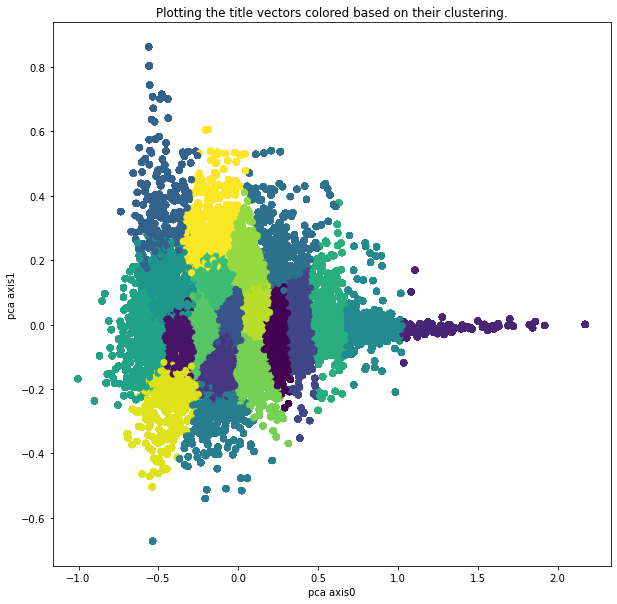

In [64]:
# Getting unique labels
u_labels = np.unique(df_clusters['cluster'])

# plotting the results:

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for i in u_labels:
    plt.scatter(Extract(df_clusters['pca_vectorized_docs'], 0), Extract(df_clusters['pca_vectorized_docs'],1) , c = df_clusters['cluster'])
plt.title('Plotting the title vectors colored based on their clustering.')
plt.xlabel('pca axis0')
plt.ylabel('pca axis1')
plt.show()

In [65]:
cluster_terms_dict = {}
for i in range(20):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    cluster_terms_dict[i] = tokens_per_cluster

df_clusters['cluster_terms'] = [0]*df_clusters.shape[0]
for index, row in df_clusters.iterrows():
    df_clusters['cluster_terms'][index] = cluster_terms_dict[row['cluster']]

C:\Users\MAHIKA\AppData\Local\Temp\ipykernel_7292\1601769658.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
df_clusters['cluster_count'] = [0]*df_clusters.shape[0]

for curr_year in range(2006, 2022):
    temp_df = df_clusters[df_clusters['year'] == curr_year]

    values = temp_df['cluster'].value_counts(dropna=False).keys().tolist()
    counts = [str(x) for x in temp_df['cluster'].value_counts(dropna=False).tolist()]
    cluster_count_dict  = dict(zip(values, counts))
    cluster_count_dict  = dict(sorted(cluster_count_dict.items()))

    for index, row in df_clusters.iterrows():
        if(df_clusters['year'][index] == curr_year):
            df_clusters['cluster_count'][index] = cluster_count_dict[row['cluster']]

df_clusters['cluster_count'] = pd.to_numeric(df_clusters['cluster_count'])

C:\Users\MAHIKA\AppData\Local\Temp\ipykernel_7292\970886594.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
df_clusters = df_clusters.sort_values(by=['year'])
df_clusters.head()

,text,tokens,cluster,vectorized_docs,year,conference,pca_vectorized_docs,axis0,axis1,cluster_terms,cluster_count
389,Aggregating Classification Accuracy through Ti...,aggregating classification accuracy time class...,17,"[0.058725074, -0.04929309, -0.12912354, 0.0408...",2006,NeurIPS,"[0.09754184257446347, 0.007898098976525872]",0.097542,0.007898,human view embedding joint knowledge,21
8877,Optimal Change-Detection and Spiking Neurons,optimal change detection spiking neurons,5,"[0.066823184, -0.069058634, -0.14313138, 0.054...",2006,NeurIPS,"[-0.0441970597474014, -0.028184108712231332]",-0.044197,-0.028184,human joint embedding approach view,26
5697,Inferring Network Structure from Co-Occurrences,inferring network structure co occurrences,16,"[0.050812878, -0.047920655, -0.13105801, 0.053...",2006,NeurIPS,"[0.005186655407960172, 0.1051313748142334]",0.005187,0.105131,attention training network equivariant relu,4
5692,Inferring Graphical Model Structure using $\el...,inferring graphical model structure using ell1...,5,"[0.063584164, -0.0632438, -0.14147124, 0.06657...",2006,NeurIPS,"[-0.07673352937213208, 0.001193850891694721]",-0.076734,0.001194,human joint embedding approach view,26
3806,Estimating Observation Functions in Dynamical ...,estimating observation functions dynamical sys...,1,"[0.06423644, -0.077366844, -0.16328114, 0.0598...",2006,NeurIPS,"[-0.34711049833102015, -0.030424964131334113]",-0.347110,-0.030425,scalable application partial estimating human,18


In [68]:
pio.renderers.default = 'notebook_connected'

fig = px.scatter(df_clusters, x="axis0", y="axis1", animation_frame="year", animation_group="cluster_terms",
            color="cluster_terms", hover_name="text", size='cluster_count', size_max=55)

# fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()